# Feature Vector Calculations
The purpose of this notebook is to write out formulas for calculating feature vector updates and to document the thought process for the implementation of feature vectors and the dictionary outside of the final program.

## Statistical Calculations

### Average
Below is the formula for calculating the current average, $\mu_{n}$, for different fields with only the calculated average from one previous time step, $\mu_{n-1}$, and the current value update for the field, $x_{n}$. This can be used on any of the fields present in the track dataset.

$$
\mu_{n} = \frac{(n-1)\mu_{n-1} + x_{n}}{n}
$$

### Standard Deviation
Below is the formula for calculating the current standard deviation, $\sigma_{n}$, with only the previously calculated standard deviation from the last time step, $\sigma_{n-1}$, and the current value update for the field, $x_{n}$. This can be used on any of the fields present in the track dataset.

$$
\sigma_{n} = \sqrt{\frac{(n-1)\sigma_{n-1}^{2} + (x_{n}-\mu_{n})^2}{n}}
$$

## Smoothness Calculations

Below are the formulas for calculating both the smoothness $M(1)$ and $M(2)$ metrics. These metrics convey the relative visual smoothness of a signal processed from any of the fields either provided by the kinematic track data or features calculated throughout the script. Added variables $q$ and $c$ are also specified in the equations. $z_n$ is any field or calculated feature at the current time interval.
$$
q_{n} = \frac{1}{n}(q_{n-1} * (n-1) + (z_{n} - z_{n-1}))
$$
$$
M(1)_n = \frac{1}{n}(M(1)_{n-1}*(n-1)+(z_{n}-z_{n-1}-q)^2)
$$
$$
c_n = \frac{1}{n}(c_{n-1}*(n-1)+|z_{n}-z_{n-1}|)
$$
$$
M(2)_n=\frac{M(1)_n}{c_n}
$$

## Euclidean Distance - 3D

Below is the three dimensional euclidean distance formula. For constructing the three dimensional coordinate space, we will use $latitude$ and $longitude$ of each track update as the $x$ and $y$ axis and $altitude$ as the $z$ axis. 

$$ d_{n}=||p-q|| = \sqrt{(lat_{a}-lat_{b})^2+(lon_{a}-lon_{b})^2+(alt_{a}-alt_{b})^2}$$

## Curvature

Using the three dimensional euclidean distance formula show above, curvature is calculated using the formula shown below where $a$, $b$, and $c$ are the calculated euclidean distances between 3 consecutive track updates (update 1 to 2, update 2 to 3, and update 1 to 3). This curvature formula will be considered a short term measurement of curvature, work is being done to investigate what a longer interval curvature measurement would look like.

$$ 
\kappa_{n} = cos^{-1}\frac{a^2-b^2-c^2}{2bc}
$$

## Heading

$$
h_{n} = tan^{-1}(lon_{n-1} - lon_{n}, lat_{n-1} - lat_{n})
$$

## Manuverability Score

$$
\phi_{n} = \frac{\mu_{speed}}{\sigma_{heading}}
$$

### Current Feature List

1. Average of speed
2. Average of heading
3. Average of curvature
4. Standard Deviation of speed
5. Standard Deviation of heading
6. Manuverability Score
7. M(1) Smoothness of range
8. M(1) Smoothness of azimuth
9. M(1) Smoothness of elevation
10. M(1) Smoothness of speed
11. M(1) Smoothness of heading
12. M(2) Smoothness of range
13. M(2) Smoothness of azimuth
14. M(2) Smoothness of elevation
15. M(2) Smoothness of speed
16. M(2) Smoothness of heading

# Feature Downselection

## Import and Process Data

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import uuid

In [4]:
gps_df = pd.read_csv("../data/raw/gps/processedGPSData.csv")
print(list(gps_df.columns))

['UpdateTime', 'Position_lat_', 'Position_lon_', 'Position_altMSL_', 'Speed', 'UUID', 'Range', 'AZ', 'EL', 'RadialVelocity']


In [5]:
ecco_df = pd.read_csv("../data/raw/crane/ecco.csv", low_memory=False)
print(list(ecco_df.columns))

ecco_uuids = ecco_df["UUID"].unique()
for ecco_uuid in ecco_uuids:
    n_plots = len(ecco_df[ecco_df["UUID"] == ecco_uuid])
    
    if n_plots > 20:
        df = ecco_df[ecco_df["UUID"] == ecco_uuid]

        identifier = str(uuid.uuid4())
        for idx, row in ecco_df.iterrows():
            if idx % 20 == 0:
                identifier = str(uuid.uuid4())
            ecco_df.at[idx, "UUID"] = identifier

ecco_df_new = ecco_df.drop(columns=['Name', 'Create Time', 'User Edit Time', 'Type', 'Associated UUID', 
                      'Note', 'Source Name', 'Source Class', 'Source LID', 'Combat ID',
                      'Object ID', 'Range To Contact', 'Bearing To Contact', 'Creator',
                      'Editor', 'Origin Position (lat)', 'Origin Position (lon)', 
                      'Origin Position (alt MSL)', '2525', 'Radar Cross Section', 
                      'Closest Time', 'Course', 'Source ID', 'Closest Distance', 
                      'Deleted', 'Deleted Time', 'AIS MMSI', 'AIS IMO', 'AIS Call Sign', 
                      'AIS Ship Type', 'AIS Destination', 'AIS ETA', 'Fused', 'Fused Tracks'])

ecco_df_new = ecco_df_new.rename(
    columns={
        'Update Time': 'UpdateTime',
        'Position (lat)': 'Position_lat_',
        'Position (lon)': 'Position_lon_',
        'Position (alt MSL)': 'Position_altMSL_',
        'Radial Velocity': 'RadialVelocity'
    }, 
    errors='raise'
)
ecco_df_new = ecco_df_new[:9603]
# There are extra rows being put into ecco_df which don't actually exist in the csv??? only 9600 something actual rows but ecco prints 17000?
# print(list(ecco_df_new.columns))
# print(ecco_df_new)

['UUID', 'Name', 'Create Time', 'Update Time', 'User Edit Time', 'Type', 'Associated UUID', 'Note', 'Source Name', 'Source Class', 'Source LID', 'Combat ID', 'Object ID', 'Range To Contact', 'Bearing To Contact', 'Creator', 'Editor', 'AZ', 'EL', 'Range', 'Position (lat)', 'Position (lon)', 'Position (alt MSL)', 'Origin Position (lat)', 'Origin Position (lon)', 'Origin Position (alt MSL)', '2525', 'Speed', 'Radar Cross Section', 'Closest Time', 'Course', 'Source ID', 'Radial Velocity', 'Closest Distance', 'Deleted', 'Deleted Time', 'AIS MMSI', 'AIS IMO', 'AIS Call Sign', 'AIS Ship Type', 'AIS Destination', 'AIS ETA', 'Fused', 'Fused Tracks']


## Feature Calculations

### Drone GPS Analysis

In [6]:
uuid_groups = gps_df.groupby('UUID')
feature_list = ['Average Speed', 'Stan. Dev. Speed', 'Average Heading', 'Stan. Dev. Heading', 'Average Curvature',
               'Maneuverability', 'M1 Range', 'M1 AZ', 'M1 EL',
               'M1 Speed', 'M1 Heading', 'M2 Range', 'M2 AZ', 'M2 EL',
               'M2 Speed', 'M2 Heading']
calc_dict = dict()
for feature in feature_list:
    calc_dict[feature] = []

def calculate_average_curvature(df):
    a = np.sqrt((group["Position_lat_"] - group["Position_lat_"].shift(-1))**2 + 
                (group["Position_lon_"] - group["Position_lon_"].shift(-1))**2 + 
                (group["Position_altMSL_"] - group["Position_altMSL_"].shift(-1))**2)
    b = np.sqrt((group["Position_lat_"] - group["Position_lat_"].shift(-2))**2 + 
                (group["Position_lon_"] - group["Position_lon_"].shift(-2))**2 + 
                (group["Position_altMSL_"] - group["Position_altMSL_"].shift(-2))**2)
    c = np.sqrt((group["Position_lat_"].shift(-1) - group["Position_lat_"].shift(-2))**2 + 
                (group["Position_lon_"].shift(-1) - group["Position_lon_"].shift(-2))**2 + 
                (group["Position_altMSL_"].shift(-1) - group["Position_altMSL_"].shift(-2))**2)
    with np.errstate(invalid="ignore"): 
        # arccos throwing invalid value error on what seems to be valid inputs
        curvature = np.arccos((a[:-2]**2 - b[:-2]**2 - c[:-2]**2)/(2 * b[:-2] * c[:-2]))
    return curvature.mean()

def calculate_m1(df, field):
    diff = (df[field].shift(-1) - df[field])[:-1]
    q = np.sum(diff) / len(df)
    m1 = np.sum((diff - q)**2)/len(df)
    return m1
    
def calculate_m2(df,field):
    diff = (df[field].shift(-1) - df[field])[:-1]
    q = np.sum(diff) / len(df)
    m1 = np.sum((diff - q)**2) / len(df)
    c = np.sum(np.abs(diff)) / len(df)
    if c == 0:
        return 0
    m2 = m1/c
    return m2

for uuid, group in uuid_groups:
    mean_speed = group['Speed'].mean()
    calc_dict['Average Speed'].append(mean_speed)
    calc_dict['Stan. Dev. Speed'].append(group['Speed'].std())
    heading = np.arctan2(group["Position_lat_"] - group["Position_lat_"].shift(-1), group["Position_lon_"] - group["Position_lon_"].shift(-1))
    group = group.assign(Heading=heading)
    calc_dict['Average Heading'].append(group['Heading'].mean())
    heading_std = heading.std()
    calc_dict['Stan. Dev. Heading'].append(group['Heading'].std())
    calc_dict['Average Curvature'].append(calculate_average_curvature(group))
    calc_dict['Maneuverability'].append(mean_speed/heading_std)
    for field in ['Speed', 'Range', 'AZ', 'EL', 'Heading']:
        calc_dict['M1 ' + field].append(calculate_m1(group, field))
        calc_dict['M2 ' + field].append(calculate_m2(group, field))


In [ ]:
for key, item in calc_dict.items():
    plt.scatter(range(len(item)),item)
    plt.title(key)
    plt.show()

#### Correlation Between Proposed Features

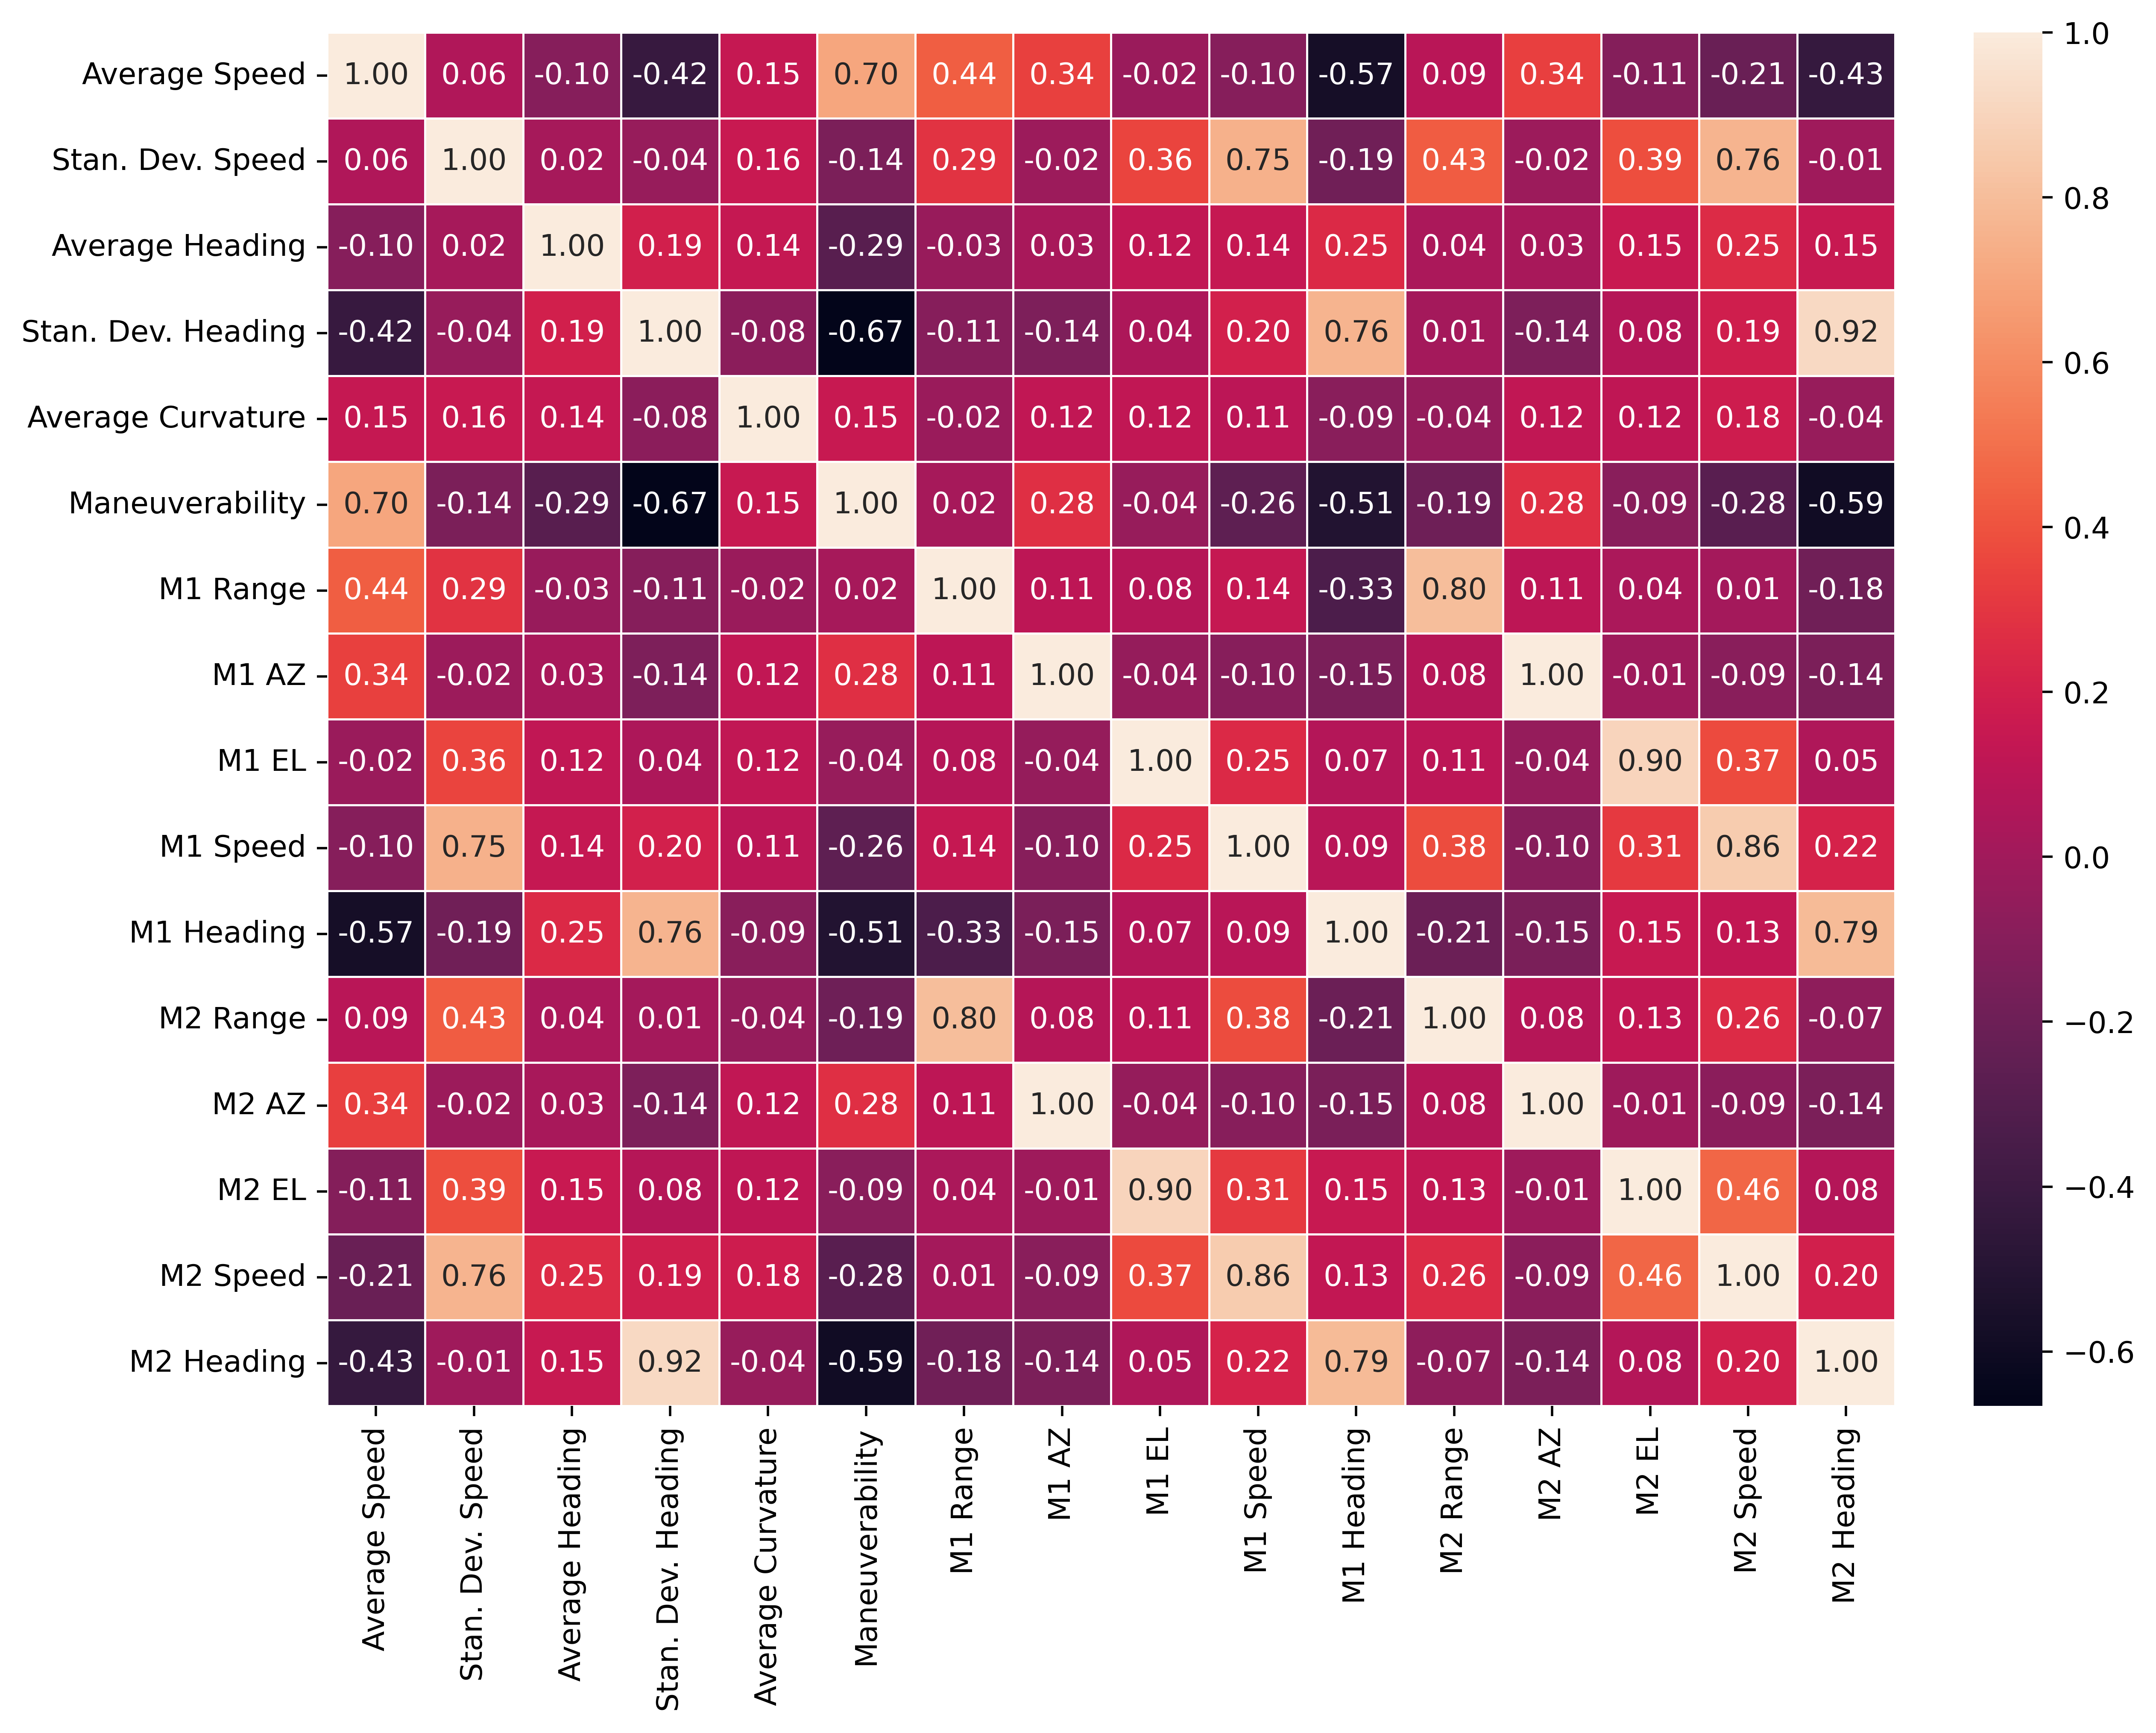

In [8]:
plt.figure(figsize=(10,8), dpi =500, constrained_layout=True)
sns.heatmap(np.corrcoef(list(calc_dict.values())),annot=True,fmt=".2f", linewidth=.5, xticklabels=calc_dict.keys(), yticklabels=calc_dict.keys())
plt.savefig('correlation_mat.png')

## ECCO Radar Analysis

In [9]:
ecco_uuid_groups = ecco_df_new.groupby('UUID')
feature_list = ['Average Speed', 'Stan. Dev. Speed', 'Average Heading', 'Stan. Dev. Heading', 'Average Curvature',
               'Maneuverability', 'M1 Range', 'M1 AZ', 'M1 EL',
               'M1 Speed', 'M1 Heading', 'M2 Range', 'M2 AZ', 'M2 EL',
               'M2 Speed', 'M2 Heading']
ecco_calc_dict = dict()
for feature in feature_list:
    ecco_calc_dict[feature] = []
i = 1
for uuid, group in ecco_uuid_groups:
    mean_speed = group['Speed'].mean()
    ecco_calc_dict['Average Speed'].append(mean_speed)
    ecco_calc_dict['Stan. Dev. Speed'].append(group['Speed'].std())
    heading = np.arctan2(group["Position_lat_"] - group["Position_lat_"].shift(-1), group["Position_lon_"] - group["Position_lon_"].shift(-1))
    group = group.assign(Heading=heading)
    ecco_calc_dict['Average Heading'].append(group['Heading'].mean())
    heading_std = heading.std()
    ecco_calc_dict['Stan. Dev. Heading'].append(group['Heading'].std())
    ecco_calc_dict['Average Curvature'].append(calculate_average_curvature(group))
    ecco_calc_dict['Maneuverability'].append(mean_speed/heading_std)
    for field in ['Speed', 'Range', 'AZ', 'EL', 'Heading']:
        ecco_calc_dict['M1 ' + field].append(calculate_m1(group, field))
        ecco_calc_dict['M2 ' + field].append(calculate_m2(group, field))
        

In [ ]:
for key, item in ecco_calc_dict.items():
    plt.scatter(range(len(item)),item)
    plt.title(key)
    plt.show()

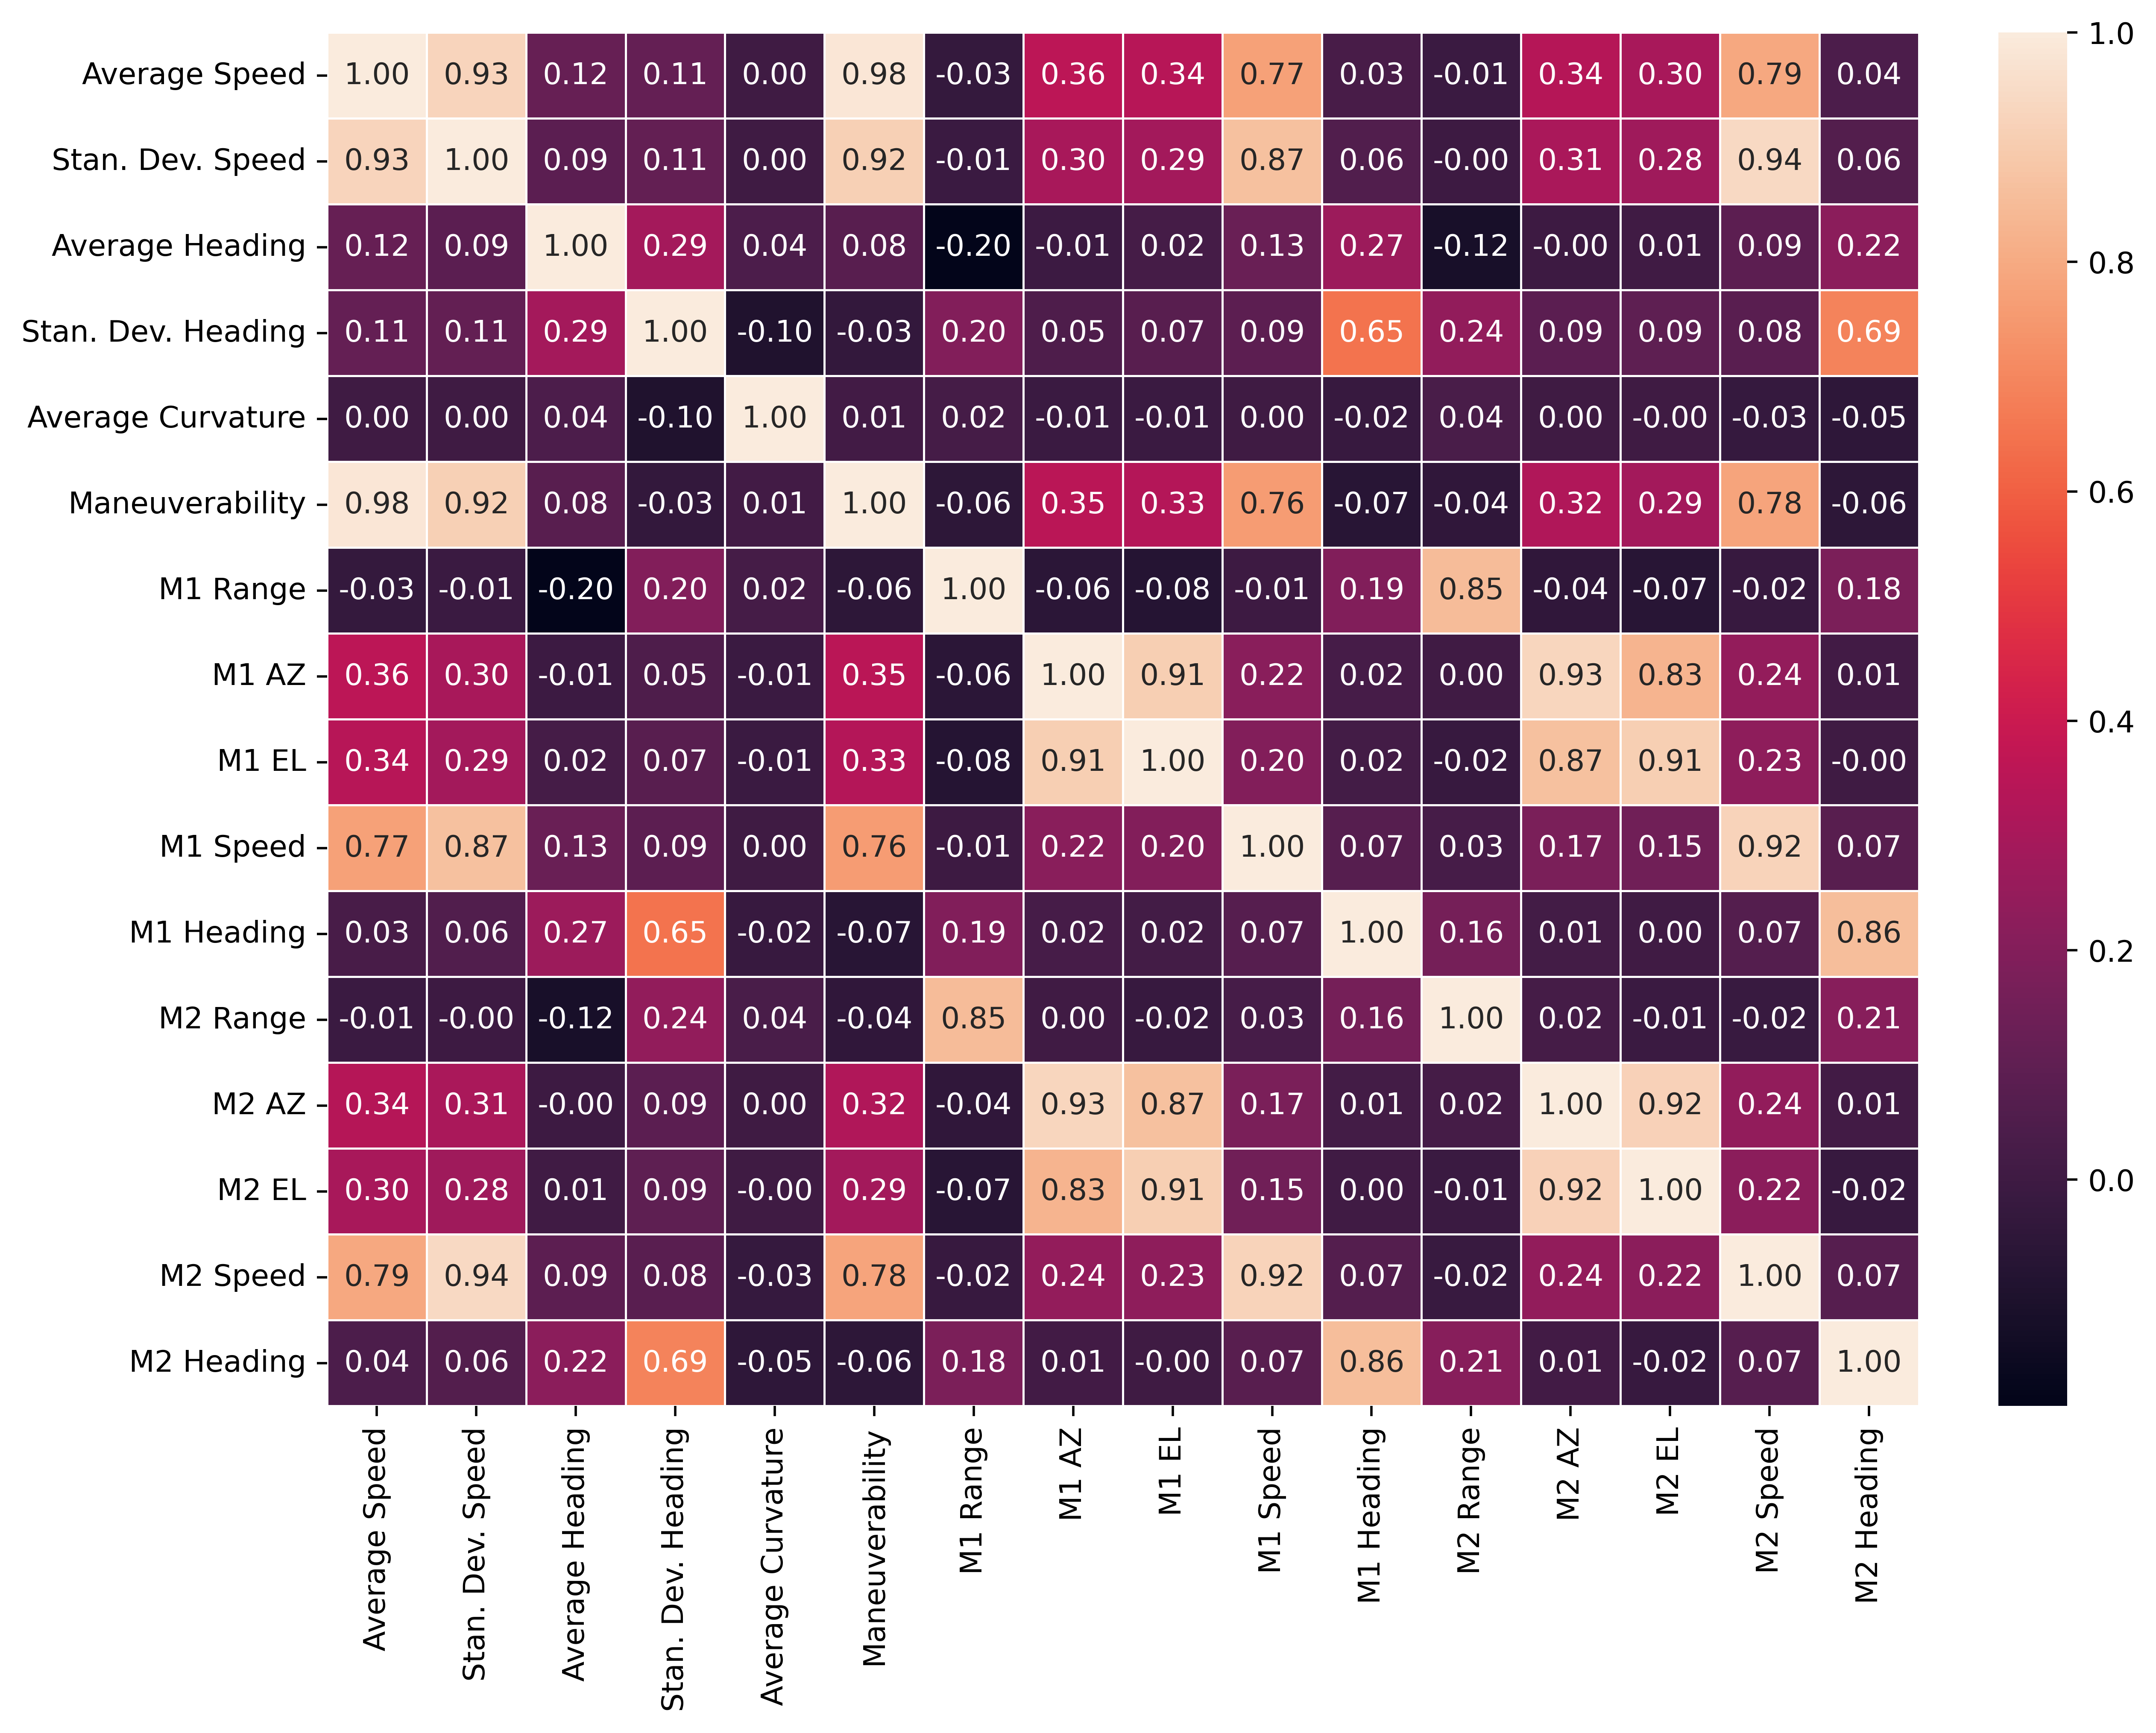

In [11]:
plt.figure(figsize=(10,8), dpi =500, constrained_layout=True)
# print(np.corrcoef(list(ecco_calc_dict.values())))
sns.heatmap(np.corrcoef(list(ecco_calc_dict.values())),annot=True,fmt=".2f", linewidth=.5, xticklabels=ecco_calc_dict.keys(), yticklabels=ecco_calc_dict.keys())
plt.savefig('ecco_correlation_mat.png')